In [6]:
import pandas as pd
import os
import numpy as np
from pathlib import Path
import sys

repo_root = Path.cwd().parent
sys.path.insert(0, str(repo_root))
from will_replication.my_utils.utils import plot_pareto_frontier

In [ ]:
BASELINE_DATASETS_LIST = [
                        "opencompass/AIME2025", #test
                        "gneubig/aime-1983-2024", #train
                        "openai/gsm8k", #test
                        "DigitalLearningGmbH/MATH-lighteval" #test
                        ]

In [8]:
MODEL_POOL = [
    "Qwen-Qwen2.5-Math-1.5B-Instruct",
    "Qwen-Qwen2.5-Math-7B-Instruct",
    "Qwen-Qwen2.5-Math-72B-Instruct",
              ]

In [9]:
# GENERATION_CONFIG
BASELINE_K=5
BASELINE_TEMP=0.6

ROUTING_MAX_K=5
ROUTING_TEMP=0.6
ROUTER_OPTIONS="easy-3_hard-1_medium-5_threshE0.9_M0.4"
# ROUTER_OPTIONS="easy-5_hard-5_medium-5_threshE0.9_M0.4"
# ROUTER_OPTIONS="easy-2_hard-4_medium-3_threshE0.9_M0.4"

ROUTING_MODEL = "Qwen_Qwen2.5-Math-1.5B-Instruct"
PROBE_MODEL_DATA_SOURCE = "DigitalLearningGmbH_MATH-lighteval"
PROBE_PROBE_K=5
PROBE_PROBE_TEMP=0.6


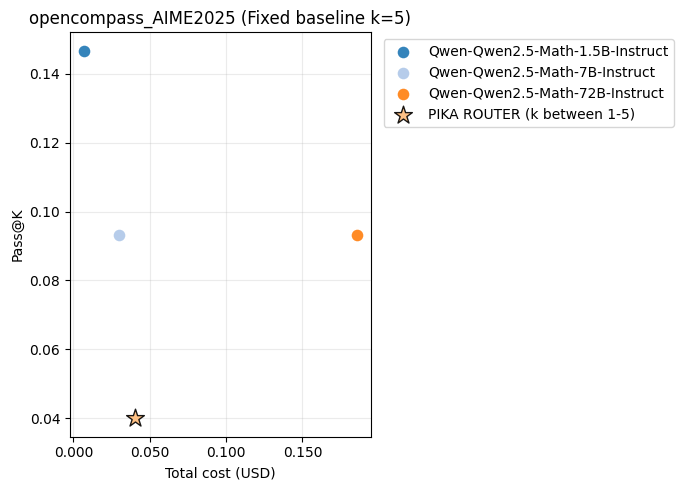

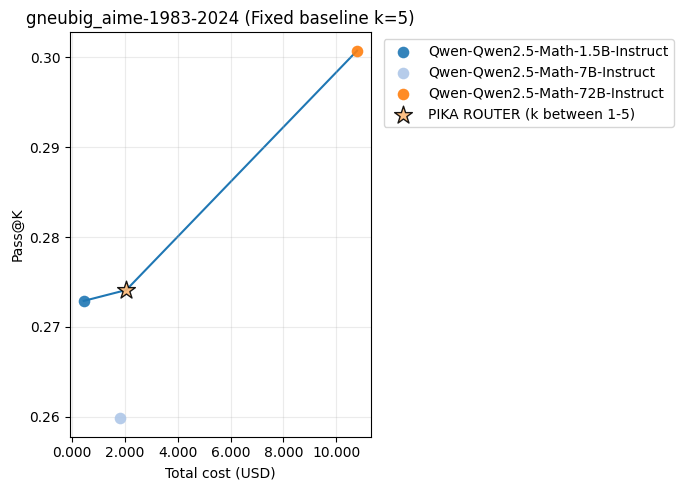

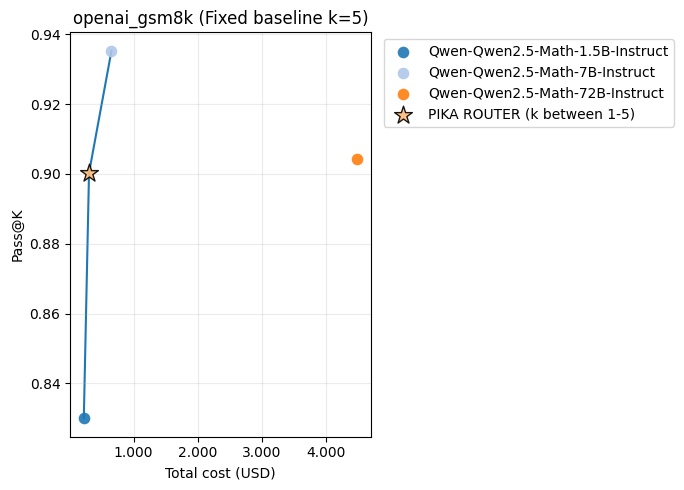

In [10]:
PLOTTING_DICT = dict()
for BASELINE_DATASET_NAME in BASELINE_DATASETS_LIST:
    BASELINE_BENCHMARK_ALIAS = "_".join(BASELINE_DATASET_NAME.split("/"))

    BENCHMARK_DATA_POINTS = []
    for MODEL_NAME in MODEL_POOL:
        if "aime-1983" in BASELINE_BENCHMARK_ALIAS: #only has train set
            BASELINE_PATH = f"../will_replication/DATA/SR_DATA/{BASELINE_BENCHMARK_ALIAS}/train-{MODEL_NAME}_maxlen_3000_k_{BASELINE_K}_temp_{BASELINE_TEMP}.parquet"
        else:
            BASELINE_PATH = f"../will_replication/DATA/SR_DATA/{BASELINE_BENCHMARK_ALIAS}/test-{MODEL_NAME}_maxlen_3000_k_{BASELINE_K}_temp_{BASELINE_TEMP}.parquet"

        BASELINE_BENCHMARK_DF = pd.read_parquet(BASELINE_PATH)

        benchmark_sr_score = BASELINE_BENCHMARK_DF["success_rate"].mean()

        if "majority_vote_is_correct" in BASELINE_BENCHMARK_DF.columns:
            benchmark_majority_vote_score = BASELINE_BENCHMARK_DF["majority_vote_is_correct"].mean()
        else:
            benchmark_majority_vote_score = np.nan

        benchmark_cost = BASELINE_BENCHMARK_DF["total_cost_usd"].sum()
        BENCHMARK_DATA_POINTS.append({"name": MODEL_NAME, "passk_score": benchmark_sr_score, "majority_vote_score":benchmark_majority_vote_score, "cost": benchmark_cost})
        
    PLOTTING_DICT[BASELINE_BENCHMARK_ALIAS] = BENCHMARK_DATA_POINTS
    PIKA_V2_DIR = f"pika_router_runs/{BASELINE_BENCHMARK_ALIAS}_routed_by_{PROBE_MODEL_DATA_SOURCE}_{ROUTING_MODEL}_probeK{PROBE_PROBE_K}_probeT{PROBE_PROBE_TEMP}_routeK{ROUTING_MAX_K}_routeT{ROUTING_TEMP}_sc_{ROUTER_OPTIONS}.parquet"
    pika_df = pd.read_parquet(PIKA_V2_DIR)

    pika_sr_score = pika_df["passk_score"].mean()
    pika_majority_vote_score = pika_df["majority_vote_is_correct"].mean()
    pika_total_cost = pika_df["total_cost_usd"].sum()

    PLOTTING_DICT[BASELINE_BENCHMARK_ALIAS] += [{"name": "PIKA ROUTER (k between 1-5)", "kind": "router", "passk_score": pika_sr_score, "majority_vote_score":pika_majority_vote_score, "cost": pika_total_cost}]

for benchmark, data_points in PLOTTING_DICT.items():
    if BASELINE_K == 1 and BASELINE_TEMP == 0:
        benchmark += " (greedy)"
    else:
        benchmark += f" (Fixed baseline k={BASELINE_K})"
    plot_pareto_frontier(data_points, benchmark, score_col="passk_score", x_label="Total cost (USD)", y_label=f"Pass@K")


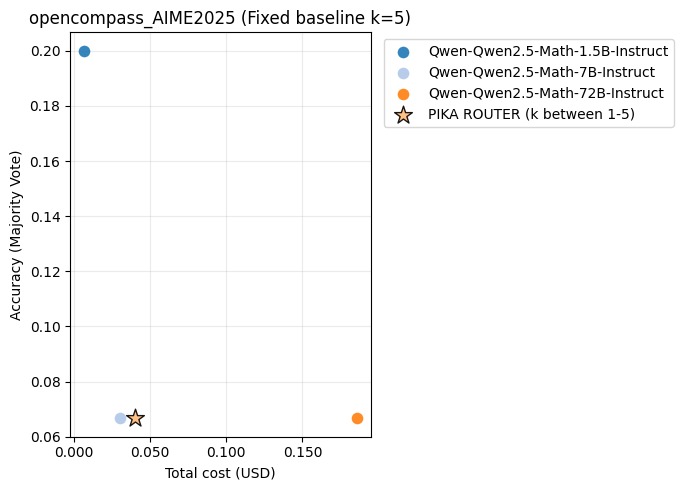

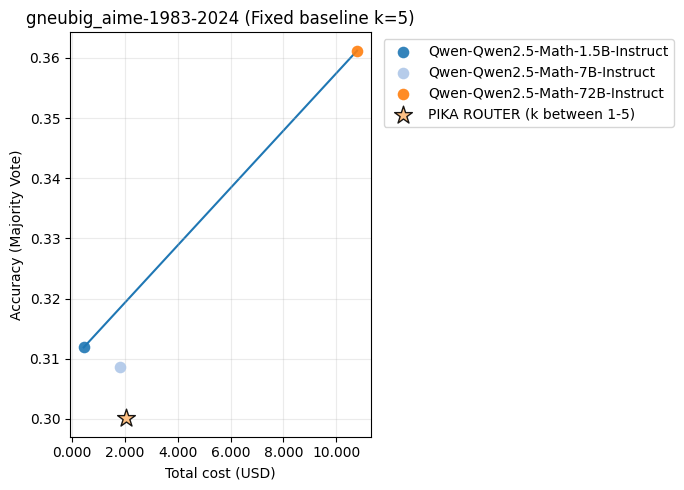

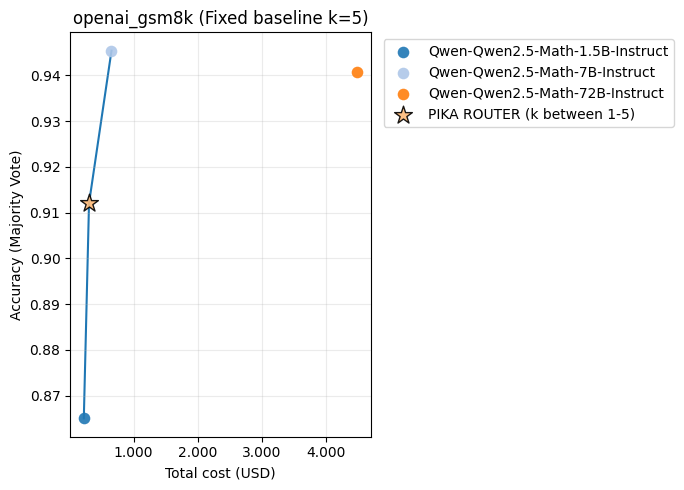

In [11]:
for benchmark, data_points in PLOTTING_DICT.items():
    if BASELINE_K == 1 and BASELINE_TEMP == 0:
        benchmark += " (greedy)"
    else:
        benchmark += f" (Fixed baseline k={BASELINE_K})"
    plot_pareto_frontier(data_points, benchmark, score_col="majority_vote_score", x_label="Total cost (USD)", y_label=f"Accuracy (Majority Vote)")